In [52]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras import layers, models, utils, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image


### Gather training and validation datasets:

In [2]:
train_dataset_path = "/kaggle/input/stanford-dogs-dataset-traintest/cropped/train"
test_dataset_path = "/kaggle/input/stanford-dogs-dataset-traintest/cropped/test"

batch_size = 32
image_height = 256
image_width = 256
seed = 123
validation_split=0.2
label_mode='categorical'
labels='inferred'

# Create the training dataset
train_dataset = utils.image_dataset_from_directory(
    train_dataset_path,
    subset="training",
    validation_split=validation_split,
    seed=seed,  
    batch_size=batch_size,
    image_size=(image_height, image_width),
    label_mode=label_mode,
    labels=labels
)

# Create the validation dataset
val_dataset = utils.image_dataset_from_directory(
    train_dataset_path,
    subset="validation",
    validation_split=validation_split,
    seed=seed,  
    batch_size=batch_size,
    image_size=(image_height, image_width),
    label_mode=label_mode, 
    labels=labels
)

# Create the test dataset
test_dataset = utils.image_dataset_from_directory(
    test_dataset_path,
    seed=seed, 
    batch_size=batch_size,
    image_size=(image_height, image_width),
    label_mode=label_mode,
)


Found 12000 files belonging to 120 classes.
Using 9600 files for training.
Found 12000 files belonging to 120 classes.
Using 2400 files for validation.
Found 8580 files belonging to 120 classes.


### Data exploration

In [3]:
# what do the classnames (breeds) look like
class_names = train_dataset.class_names
names=[]
for name in class_names :
    names.append(name.split("-")[1]) 

print(names[:10]) # Printing some breeds

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound']


In [4]:
num_classes = len(class_names)
num_classes

120

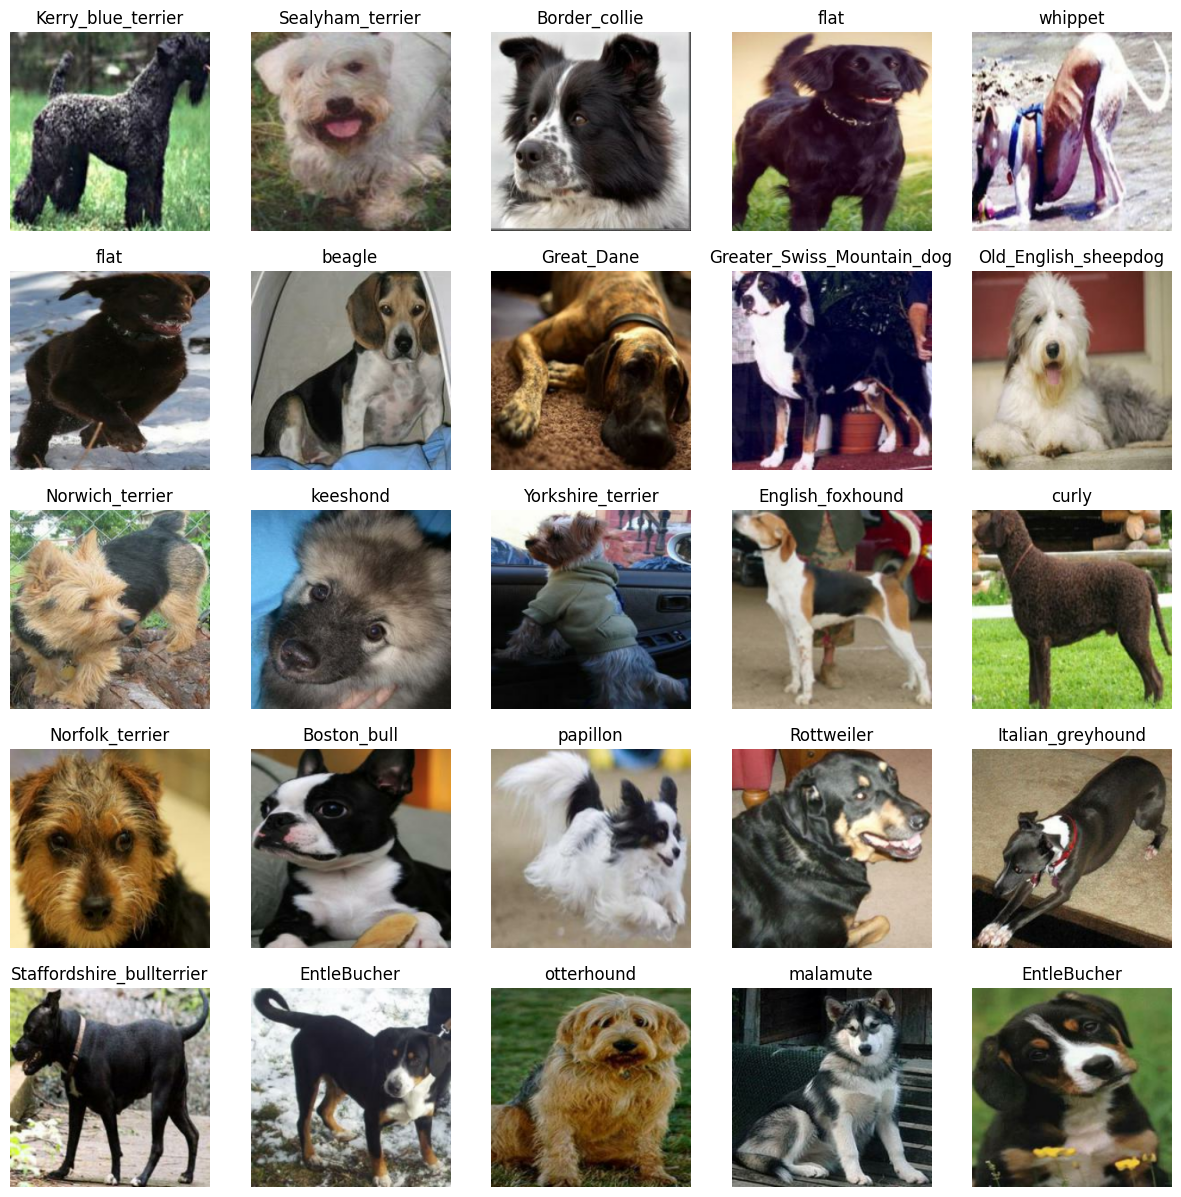

In [7]:
# show a sample of images and their breed
plt.figure(figsize=(15, 15))
for images, labels in train_dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])].split("-")[1])
        plt.axis("off")

In [6]:
# stop the training after a certain time if it's not improving
early_stopper = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 3, 
                   verbose = 1, 
                   restore_best_weights = True)

callbacks = [early_stopper]

In [7]:
# Preprocess the images
preprocessed_train_images = train_dataset.map(
    lambda image, label: (preprocess_input(image), label)
)

preprocessed_val_images = val_dataset.map(
    lambda image, label: (preprocess_input(image), label)
)

In [8]:
# build the first/base model
vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=(image_height,image_width,3))

# Freeze the convolutional layers of the VGG16 base
vgg16_base.trainable = False

model = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
#     layers.Dropout(0.5), #commonly used in neural networks to prevent overfitting
    layers.Dense(num_classes, activation='softmax')  # num_classes = 120
])

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dense_1 (Dense)             (None, 120)               61560     
                                                                 
Total params: 31553976 (120.37 MB)
Trainable params: 16839288 (64.24 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [9]:
# Compile the model
model.compile(Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 100
history = model.fit(preprocessed_train_images,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=preprocessed_val_images,
                    callbacks=[early_stopper],
                    verbose=1)

Epoch 1/100


I0000 00:00:1707241324.030133     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 [==============================] - 73s 197ms/step - loss: 6.2637 - accuracy: 0.0995 - val_loss: 4.0249 - val_accuracy: 0.1642
Epoch 2/100
300/300 [==============================] - 62s 204ms/step - loss: 1.9581 - accuracy: 0.5109 - val_loss: 3.2743 - val_accuracy: 0.3400
Epoch 3/100
300/300 [==============================] - 62s 204ms/step - loss: 0.5174 - accuracy: 0.8548 - val_loss: 3.1990 - val_accuracy: 0.4125
Epoch 4/100
300/300 [==============================] - 62s 204ms/step - loss: 0.1182 - accuracy: 0.9701 - val_loss: 3.4678 - val_accuracy: 0.4363
Epoch 5/100
300/300 [==============================] - 62s 204ms/step - loss: 0.0536 - accuracy: 0.9908 - val_loss: 3.3935 - val_accuracy: 0.4588
Epoch 6/100
300/300 [==============================] - 61s 204ms/step - loss: 0.0482 - accuracy: 0.9939 - val_loss: 3.4067 - val_accuracy: 0.4554
Epoch 7/100
300/300 [==============================] - 61s 203ms/step - loss: 0.0525 - accuracy: 0.9928 - val_loss: 3.6610 - val_accurac

In [10]:
preprocessed_test_images = test_dataset.map(
    lambda image, label: (preprocess_input(image), label)
)


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(preprocessed_test_images)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

269/269 [==============================] - 44s 160ms/step - loss: 3.1941 - accuracy: 0.4556
Test Loss: 3.194091796875, Test Accuracy: 0.45559442043304443


In [11]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

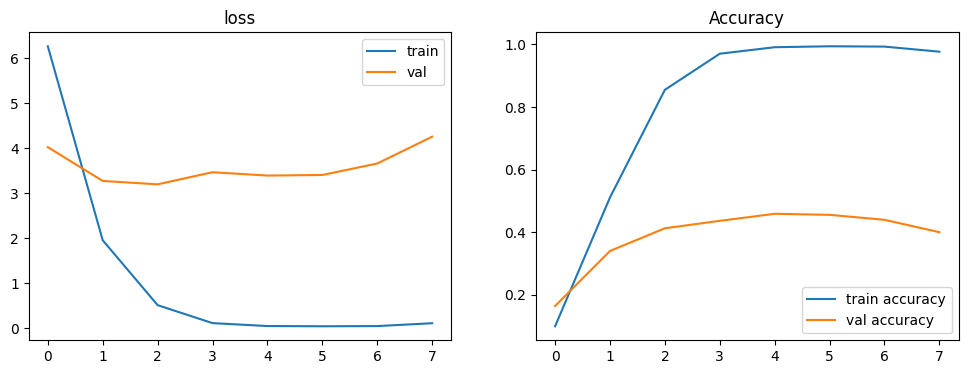

In [12]:
plot_history(history)

In [44]:
def format_predictions(predictions, class_names, min_probability=0.01):
    # Convert the predicted probabilities to percentages
    predicted_probabilities = predictions * 100
    
    # Create a dictionary mapping class indices to class names
    class_mapping = {i: class_name for i, class_name in enumerate(class_names)}
    
    # Sort the predictions by probability in descending order
    sorted_indices = np.argsort(-predicted_probabilities[0])
    
    # Filter out indices with probabilities higher than min_probability
    filtered_indices = [i for i in sorted_indices if predicted_probabilities[0][i] >= min_probability]

    # Construct the formatted output string
    formatted_output = ""
    for i in filtered_indices:
        prob = predicted_probabilities[0][i]
        class_name = class_names[i].split('-')[1].replace('_', ' ').title()
        formatted_output += f"{prob:.2f}%\t {class_name}\n"
    
    return formatted_output

In [29]:
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(image_height, image_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(img_array)
    
    return preprocessed_img

In [58]:
german_shorthaired_pointer = '/kaggle/input/dogs-to-test/media_12c156f7f2f321c4bea0b16984b38b48bb14c1814.jpeg'
border_collie = '/kaggle/input/dogs-to-test/download.jpeg'
grumpy = '/kaggle/input/dogs-to-test/IMG_20230422_113329.jpg'

1/1 [==============================] - 0s 21ms/step
99.89%	 German Short
0.11%	 Chesapeake Bay Retriever



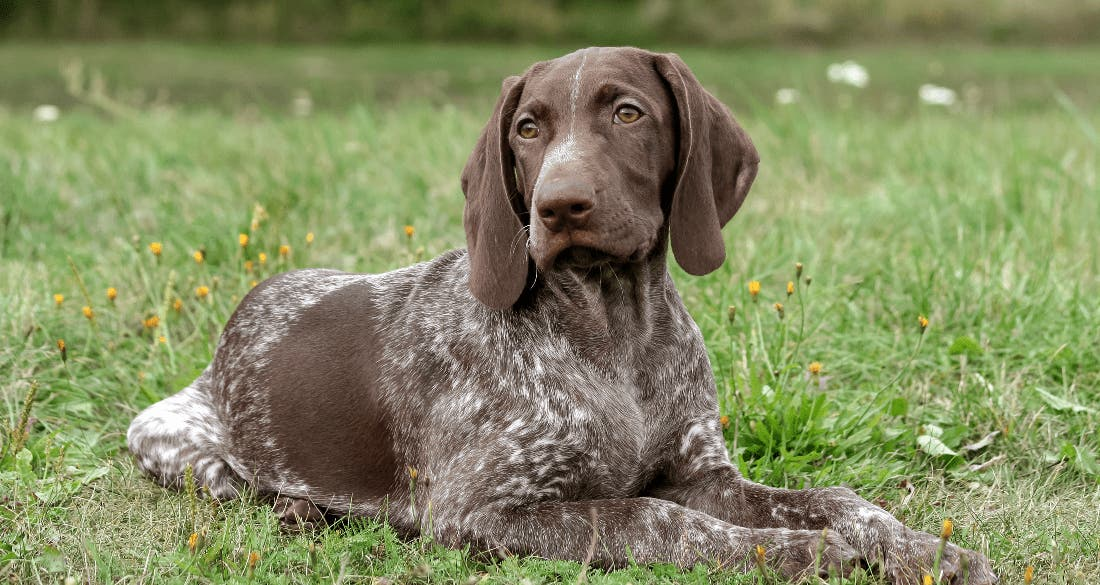

In [54]:
predictions = model.predict(preprocess_image(german_shorthaired_pointer)) 
output = format_predictions(predictions, class_names)
print(output)
Image(filename=german_shorthaired_pointer)

1/1 [==============================] - 0s 20ms/step
95.45%	 Collie
4.53%	 Border Collie



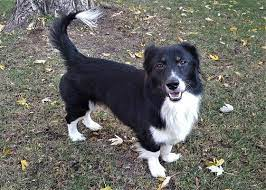

In [56]:
predictions = model.predict(preprocess_image(border_collie)) 
output = format_predictions(predictions, class_names)
print(output)
Image(filename=border_collie)

1/1 [==============================] - 0s 21ms/step
47.25%	 Dandie Dinmont
19.27%	 Border Terrier
12.46%	 Chesapeake Bay Retriever
6.10%	 Golden Retriever
5.98%	 German Shepherd
1.58%	 English Foxhound
1.38%	 Toy Terrier
1.31%	 Lhasa
1.30%	 Cairn
0.59%	 Greater Swiss Mountain Dog
0.56%	 Airedale
0.51%	 Bloodhound
0.34%	 Pekinese
0.33%	 Black
0.16%	 Keeshond
0.14%	 Beagle
0.14%	 Gordon Setter
0.13%	 Kelpie
0.10%	 Saint Bernard
0.06%	 Irish Terrier
0.04%	 Standard Poodle
0.04%	 Norwegian Elkhound
0.03%	 English Setter
0.02%	 Affenpinscher
0.02%	 Dhole
0.02%	 Cocker Spaniel
0.02%	 Irish Setter
0.02%	 Redbone
0.01%	 Malamute
0.01%	 Bull Mastiff
0.01%	 Basset



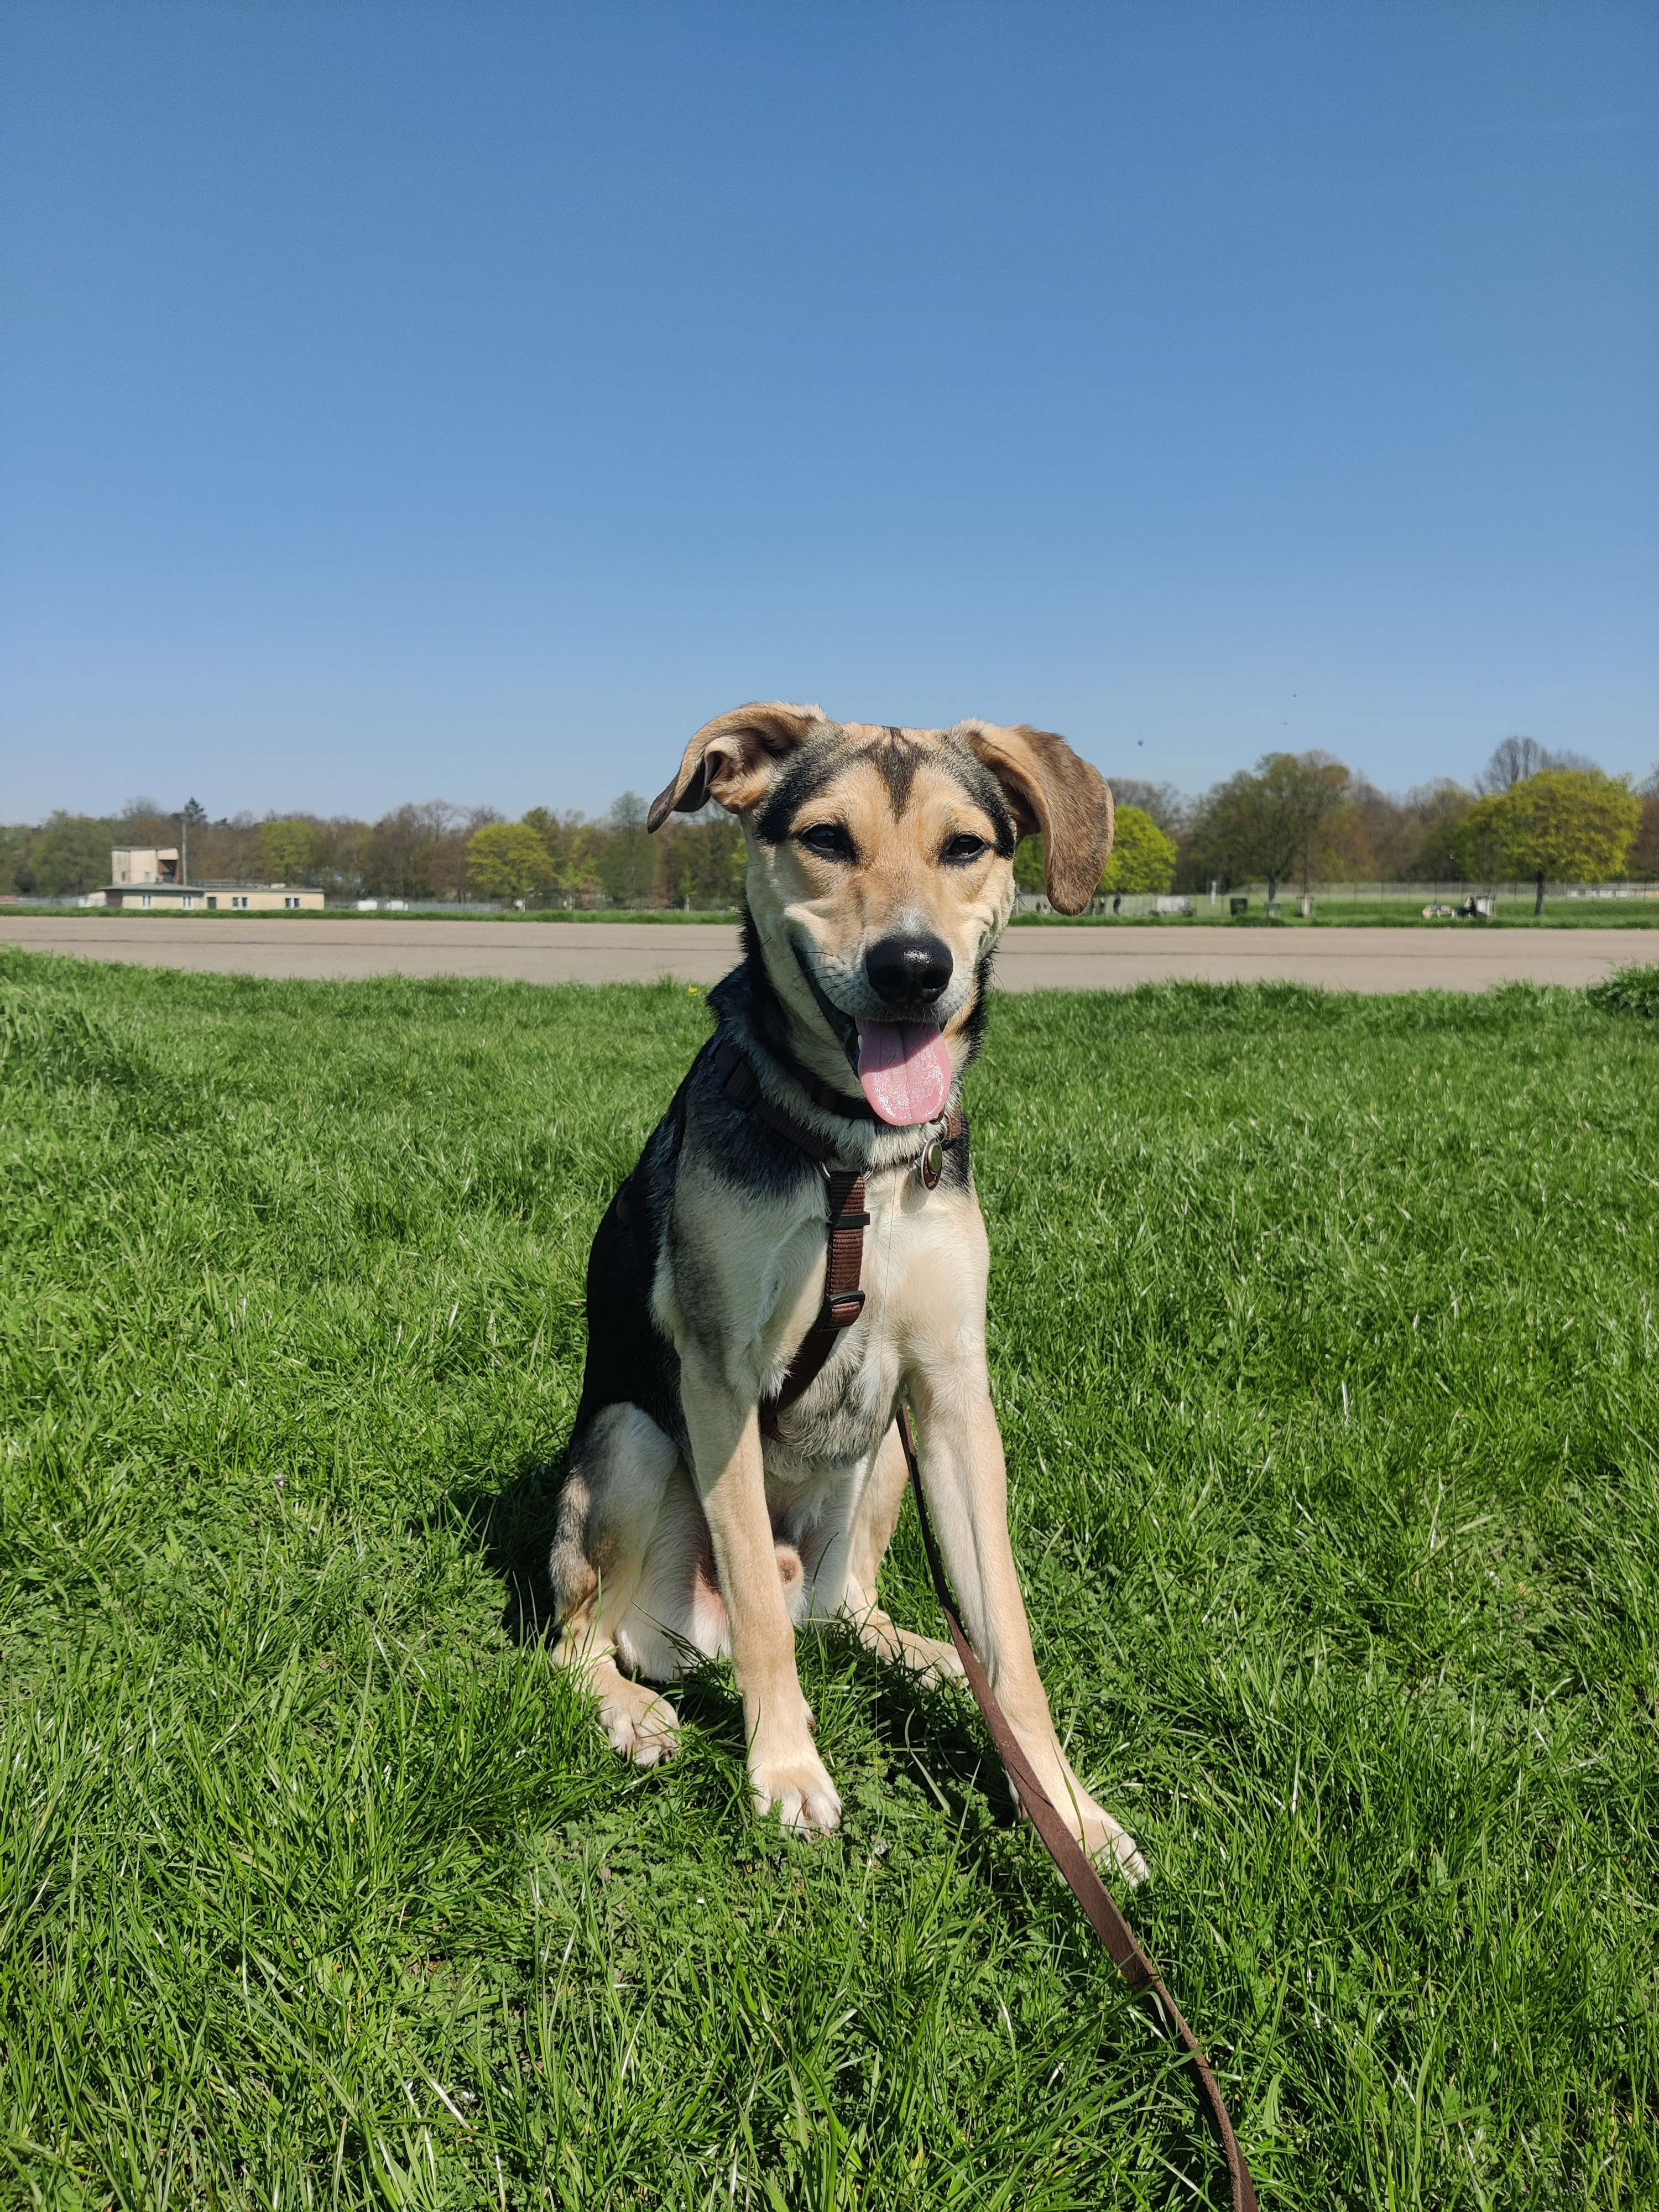

In [59]:
predictions = model.predict(preprocess_image(grumpy)) 
output = format_predictions(predictions, class_names)
print(output)
Image(filename=grumpy)